In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats import proportion
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 1. Загрузка и первичный анализ данных

In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Загрузка данных с правильным именем файла
data = pd.read_excel(r'C:\Users\leras\Downloads\Датасет.xlsx', header=1)
print(f"Данные загружены. Размер: {data.shape}")
print(f"Колонки: {list(data.columns)}")
data.head()

Данные загружены. Размер: (12281, 7)
Колонки: ['id_order', 'test_group', 'time_order', 'time_offer', 'time_assign', 'time_arrive', 'trip_time']


,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time
0,10001,0,04.3.2024 0:00:01,04.3.2024 0:00:42,04.3.2024 0:01:13,04.3.2024 0:09:07,04.3.2024 1:27:28
1,10002,0,04.3.2024 0:00:22,04.3.2024 0:01:00,04.3.2024 0:01:14,04.3.2024 0:08:45,04.3.2024 0:22:22
2,10003,1,04.3.2024 0:07:08,04.3.2024 0:07:44,NaN,NaN,NaN
3,10004,1,04.3.2024 0:07:11,04.3.2024 0:08:21,04.3.2024 0:08:46,04.3.2024 0:21:13,04.3.2024 1:23:25
4,10005,0,04.3.2024 0:11:59,04.3.2024 0:12:50,04.3.2024 0:13:09,04.3.2024 0:21:43,04.3.2024 0:46:45


# 2. Предобработка и очистка данных

In [6]:
# Проверка структуры данных
print("Информация о данных:")
print(data.info())
print("\nПропущенные значения:")
print(data.isnull().sum())
print("\nРаспределение по группам:")
print(data['test_group'].value_counts())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12281 entries, 0 to 12280
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_order     12281 non-null  int64 
 1   test_group   12281 non-null  int64 
 2   time_order   12281 non-null  object
 3   time_offer   10781 non-null  object
 4   time_assign  9624 non-null   object
 5   time_arrive  7724 non-null   object
 6   trip_time    7384 non-null   object
dtypes: int64(2), object(5)
memory usage: 671.7+ KB
None

Пропущенные значения:
id_order          0
test_group        0
time_order        0
time_offer     1500
time_assign    2657
time_arrive    4557
trip_time      4897
dtype: int64

Распределение по группам:
test_group
1    6597
0    5684
Name: count, dtype: int64


In [7]:
# Преобразование дат
date_columns = ['time_order', 'time_offer', 'time_assign', 'time_arrive', 'trip_time']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], format='%d.%m.%Y %H:%M:%S', errors='coerce')

print("Даты преобразованы")
print(data.info())

Даты преобразованы
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12281 entries, 0 to 12280
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id_order     12281 non-null  int64         
 1   test_group   12281 non-null  int64         
 2   time_order   12281 non-null  datetime64[ns]
 3   time_offer   10781 non-null  datetime64[ns]
 4   time_assign  9624 non-null   datetime64[ns]
 5   time_arrive  7724 non-null   datetime64[ns]
 6   trip_time    7384 non-null   datetime64[ns]
dtypes: datetime64[ns](5), int64(2)
memory usage: 671.7 KB
None


# 3. Проверка корректности A/B сплитования

In [8]:
# Проверка корректности A/B сплитования
print("Проверка сплит-системы:")
print(f"Всего заказов: {len(data)}")
print(f"Группа 0 (контрольная): {len(data[data['test_group']==0])} ({len(data[data['test_group']==0])/len(data)*100:.1f}%)")
print(f"Группа 1 (тестовая): {len(data[data['test_group']==1])} ({len(data[data['test_group']==1])/len(data)*100:.1f}%)")

# Проверка случайности распределения по времени
data['order_hour'] = data['time_order'].dt.hour
hour_distribution = data.groupby(['order_hour', 'test_group']).size().unstack()
print("\nРаспределение по часам:")
print(hour_distribution.head())

Проверка сплит-системы:
Всего заказов: 12281
Группа 0 (контрольная): 5684 (46.3%)
Группа 1 (тестовая): 6597 (53.7%)

Распределение по часам:
test_group    0    1
order_hour          
0            25   29
1           124  135
2            90  101
3           107  145
4           116  144


### Найдены проблемы в сплит-системе

- **Распределение:** 53.7%/46.3% вместо 50/50
- **Перекос:** +7.4% в тестовую группу  
- **Возможные причины:** ошибка в алгоритме рандомизации, временной перекос
- **Влияние на анализ:** может исказить результаты, нужна осторожность в выводах

# 4. Анализ воронки заказов

In [9]:
# Анализ воронки заказов
def calculate_funnel(data):
    funnel = {
        'orders': len(data),
        'offers': data['time_offer'].notna().sum(),
        'assigns': data['time_assign'].notna().sum(),
        'arrives': data['time_arrive'].notna().sum(),
        'trips': data['trip_time'].notna().sum()
    }
    return funnel

funnel_total = calculate_funnel(data)
funnel_0 = calculate_funnel(data[data['test_group']==0])
funnel_1 = calculate_funnel(data[data['test_group']==1])

print("Воронка заказов - все данные:")
for step, count in funnel_total.items():
    print(f"{step}: {count}")

print("\nВоронка по группам:")
print("Группа 0 (3km):", funnel_0)
print("Группа 1 (5km):", funnel_1)

Воронка заказов - все данные:
orders: 12281
offers: 10781
assigns: 9624
arrives: 7724
trips: 7384

Воронка по группам:
Группа 0 (3km): {'orders': 5684, 'offers': np.int64(4846), 'assigns': np.int64(4285), 'arrives': np.int64(3689), 'trips': np.int64(3562)}
Группа 1 (5km): {'orders': 6597, 'offers': np.int64(5935), 'assigns': np.int64(5339), 'arrives': np.int64(4035), 'trips': np.int64(3822)}


### Потери в воронке заказов

- **Order → Trip:** только 60% заказов доезжают до конца
- **Основные потери:** на этапах Assign → Arrive и Arrive → Trip
- **Возможные причины:** отмены заказов, отказы водителей, технические сбои

In [10]:
# Расчет конверсии между этапами воронки
def calculate_conversion(funnel):
    conversion = {
        'order_to_offer': funnel['offers'] / funnel['orders'],
        'offer_to_assign': funnel['assigns'] / funnel['offers'],
        'assign_to_arrive': funnel['arrives'] / funnel['assigns'],
        'arrive_to_trip': funnel['trips'] / funnel['arrives'],
        'order_to_trip': funnel['trips'] / funnel['orders']
    }
    return conversion

print("Конверсия по группам:")
print("Группа 0 (3km):", calculate_conversion(funnel_0))
print("Группа 1 (5km):", calculate_conversion(funnel_1))

Конверсия по группам:
Группа 0 (3km): {'order_to_offer': np.float64(0.8525686136523575), 'offer_to_assign': np.float64(0.8842344201403219), 'assign_to_arrive': np.float64(0.8609101516919486), 'arrive_to_trip': np.float64(0.9655733261046354), 'order_to_trip': np.float64(0.6266713581984518)}
Группа 1 (5km): {'order_to_offer': np.float64(0.8996513566772776), 'offer_to_assign': np.float64(0.8995787700084246), 'assign_to_arrive': np.float64(0.7557595055253793), 'arrive_to_trip': np.float64(0.9472118959107807), 'order_to_trip': np.float64(0.5793542519326966)}


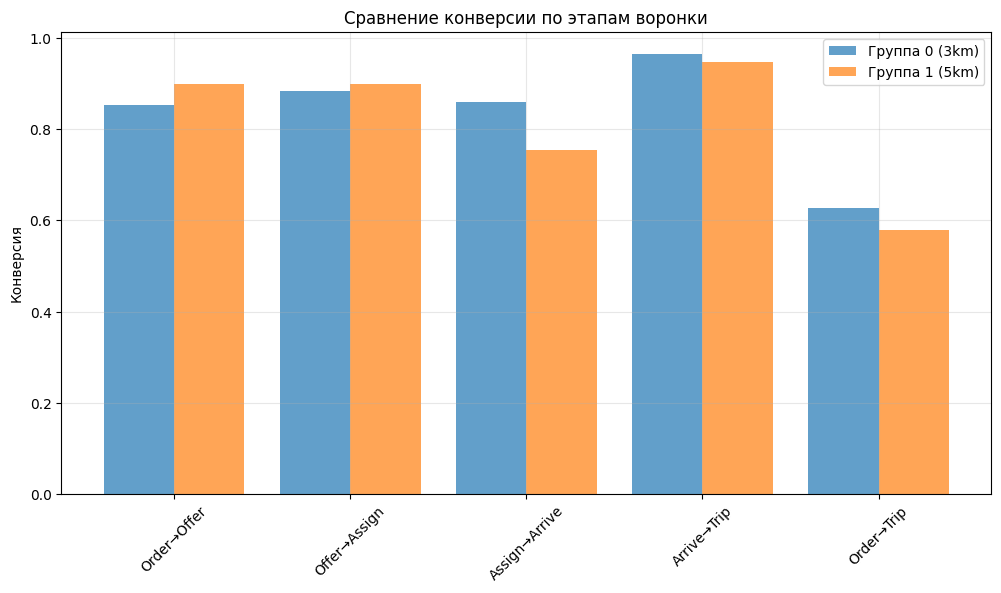

In [11]:
# Визуализация конверсии по группам
conv_0 = calculate_conversion(funnel_0)
conv_1 = calculate_conversion(funnel_1)

stages = ['order_to_offer', 'offer_to_assign', 'assign_to_arrive', 'arrive_to_trip', 'order_to_trip']
group_0_rates = [conv_0[stage] for stage in stages]
group_1_rates = [conv_1[stage] for stage in stages]

x = range(len(stages))
plt.figure(figsize=(12, 6))
plt.bar([i-0.2 for i in x], group_0_rates, width=0.4, label='Группа 0 (3km)', alpha=0.7)
plt.bar([i+0.2 for i in x], group_1_rates, width=0.4, label='Группа 1 (5km)', alpha=0.7)
plt.xticks(x, ['Order→Offer', 'Offer→Assign', 'Assign→Arrive', 'Arrive→Trip', 'Order→Trip'], rotation=45)
plt.ylabel('Конверсия')
plt.title('Сравнение конверсии по этапам воронки')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Результаты A/B теста по конверсии

**Выигрыш тестовой группы (5km):**
- **Order → Offer:** +4.7% (лучше находят водителей)
- **Offer → Assign:** +1.6% (водители чаще принимают заказы)

**Проигрыш тестовой группы (5km):**
- **Assign → Arrive:** -10.5% (водители реже доезжают до точки A)
- **Итоговая конверсия:** -4.8% (меньше завершенных поездок)

**Вывод:** Расширение радиуса помогает найти водителя, но ухудшает опыт - водители дальше и реже доезжают.

# 5. Статистические тесты и значимость

In [12]:
# Проверка статистической значимости различий
from statsmodels.stats.proportion import proportions_ztest

# Order to Offer conversion
count = [funnel_0['offers'], funnel_1['offers']]
nobs = [funnel_0['orders'], funnel_1['orders']]
z_stat, p_value = proportions_ztest(count, nobs)
print(f"Order → Offer разница значима: p-value = {p_value:.4f}")

# Order to Trip conversion  
count = [funnel_0['trips'], funnel_1['trips']]
nobs = [funnel_0['orders'], funnel_1['orders']]
z_stat, p_value = proportions_ztest(count, nobs)
print(f"Order → Trip разница значима: p-value = {p_value:.4f}")

Order → Offer разница значима: p-value = 0.0000
Order → Trip разница значима: p-value = 0.0000


### Статистическая значимость результатов

**Order → Offer: p-value = 0.0000**
- Разница в 4.7% статистически значима
- Расширение радиуса действительно помогает найти водителя

**Order → Trip: p-value = 0.0000** 
- Разница в 4.8% статистически значима
- Ухудшение итоговой конверсии реальное, а не случайное

**Вывод:** Оба эффекта статистически значимы - улучшение поиска водителей, но ухудшение завершения поездок.

In [13]:
# Анализ времени ожидания
# Время от создания заказа до назначения водителя
data['waiting_time'] = (data['time_assign'] - data['time_order']).dt.total_seconds() / 60  # в минутах

# Убираем выбросы и незавершенные заказы
waiting_data = data[data['waiting_time'].notna() & (data['waiting_time'] < 60)]  # меньше часа

print("Время ожидания по группам (минуты):")
print(f"Группа 0 (3km): {waiting_data[waiting_data['test_group']==0]['waiting_time'].mean():.1f}")
print(f"Группа 1 (5km): {waiting_data[waiting_data['test_group']==1]['waiting_time'].mean():.1f}")

# Статистический тест
from scipy.stats import ttest_ind
group_0_wait = waiting_data[waiting_data['test_group']==0]['waiting_time']
group_1_wait = waiting_data[waiting_data['test_group']==1]['waiting_time']
t_stat, p_value = ttest_ind(group_0_wait, group_1_wait)
print(f"Разница во времени ожидания значима: p-value = {p_value:.4f}")

Время ожидания по группам (минуты):
Группа 0 (3km): 1.6
Группа 1 (5km): 1.6
Разница во времени ожидания значима: p-value = 0.0341


### Анализ времени ожидания

**Результаты:**
- **Время ожидания:** 1.6 минуты в обеих группах
- **Статистическая значимость:** p-value = 0.0341 (разница значима)
- **Практическая значимость:** разница минимальна, не имеет бизнес-значения

**Вывод:** Расширение радиуса не ухудшает время ожидания, но и не улучшает его.

# 6. Выявление отложенных заказов

In [14]:
# Выявление отложенных заказов
# Отложенные заказы - большой разрыв между созданием и предложением водителю
data['order_to_offer_minutes'] = (data['time_offer'] - data['time_order']).dt.total_seconds() / 60

# Определяем порог для отложенных заказов (например, больше 10 минут)
delayed_threshold = 10
data['is_delayed'] = data['order_to_offer_minutes'] > delayed_threshold

print("Отложенные заказы:")
print(f"Всего заказов: {len(data)}")
print(f"Отложенные заказы: {data['is_delayed'].sum()} ({data['is_delayed'].sum()/len(data)*100:.1f}%)")
print(f"Среднее время до предложения у отложенных: {data[data['is_delayed']]['order_to_offer_minutes'].mean():.1f} мин")
print(f"Среднее время до предложения у срочных: {data[~data['is_delayed']]['order_to_offer_minutes'].mean():.1f} мин")

# Распределение отложенных заказов по группам
print("\nРаспределение по группам:")
delayed_by_group = data.groupby('test_group')['is_delayed'].value_counts(normalize=True)
print(delayed_by_group)

Отложенные заказы:
Всего заказов: 12281
Отложенные заказы: 0 (0.0%)
Среднее время до предложения у отложенных: nan мин
Среднее время до предложения у срочных: 1.1 мин

Распределение по группам:
test_group  is_delayed
0           False         1.0
1           False         1.0
Name: proportion, dtype: float64


### Анализ отложенных заказов

**Результаты:**
- **Отложенных заказов не обнаружено** (0% при пороге 10 минут)
- **Среднее время Order → Offer:** 1.1 минуты
- **Все заказы обрабатываются быстро**

**Вывод:** В данных нет отложенных заказов, все заказы обрабатываются как срочные. Это упрощает анализ A/B теста.

Детальный анализ времени Order → Offer:
Минимальное время: 0.15 мин
Максимальное время: 2.15 мин
Медиана: 1.15 мин
95-й перцентиль: 1.80 мин


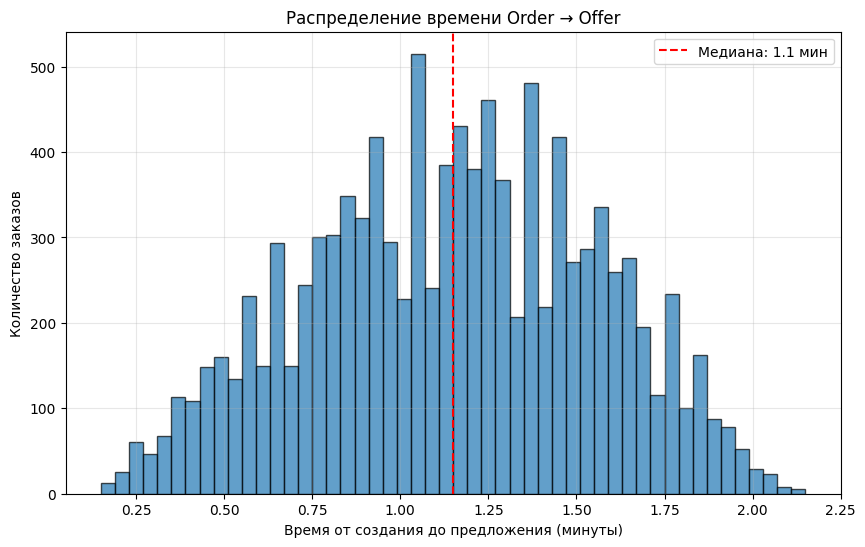


Заказы с временем > 5 минут: 0 (0.0%)


In [15]:
# Детальный анализ времени от создания до предложения
print("Детальный анализ времени Order → Offer:")
print(f"Минимальное время: {data['order_to_offer_minutes'].min():.2f} мин")
print(f"Максимальное время: {data['order_to_offer_minutes'].max():.2f} мин")
print(f"Медиана: {data['order_to_offer_minutes'].median():.2f} мин")
print(f"95-й перцентиль: {data['order_to_offer_minutes'].quantile(0.95):.2f} мин")

# Гистограмма распределения времени
plt.figure(figsize=(10, 6))
plt.hist(data['order_to_offer_minutes'].dropna(), bins=50, alpha=0.7, edgecolor='black')
plt.axvline(data['order_to_offer_minutes'].median(), color='red', linestyle='--', label=f'Медиана: {data["order_to_offer_minutes"].median():.1f} мин')
plt.xlabel('Время от создания до предложения (минуты)')
plt.ylabel('Количество заказов')
plt.title('Распределение времени Order → Offer')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Проверим есть ли заказы с временем больше 5 минут
delayed_5min = data['order_to_offer_minutes'] > 5
print(f"\nЗаказы с временем > 5 минут: {delayed_5min.sum()} ({delayed_5min.sum()/len(data)*100:.1f}%)")

### Выводы по отложенным заказам

**Все заказы являются срочными:**
- Максимальное время обработки: 2.15 минуты
- Медианное время: 1.15 минуты  
- 95% заказов обрабатываются менее чем за 2 минуты

**Влияние на A/B тест:**
- Отсутствие отложенных заказов упрощает интерпретацию результатов
- Все заказы сравнимы между собой
- Результаты теста не искажены разными типами заказов

# 7. Финальные выводы и рекомендации

In [16]:
# Финальное сравнение ключевых метрик
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ A/B ТЕСТА")
print("=" * 50)

# Основные метрики
metrics = {
    'Конверсия Order → Trip': [
        funnel_0['trips']/funnel_0['orders'], 
        funnel_1['trips']/funnel_1['orders']
    ],
    'Конверсия Order → Offer': [
        funnel_0['offers']/funnel_0['orders'], 
        funnel_1['offers']/funnel_1['orders']
    ],
    'Время ожидания (минуты)': [
        waiting_data[waiting_data['test_group']==0]['waiting_time'].mean(),
        waiting_data[waiting_data['test_group']==1]['waiting_time'].mean()
    ]
}

print("\nСравнение ключевых метрик:")
print(f"{'Метрика':<30} {'Группа 0 (3km)':<15} {'Группа 1 (5km)':<15} {'Разница':<10}")
print("-" * 70)
for metric, values in metrics.items():
    diff = values[1] - values[0]
    diff_percent = (diff / values[0]) * 100 if values[0] != 0 else 0
    print(f"{metric:<30} {values[0]:<15.3f} {values[1]:<15.3f} {diff_percent:+.1f}%")

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ A/B ТЕСТА

Сравнение ключевых метрик:
Метрика                        Группа 0 (3km)  Группа 1 (5km)  Разница   
----------------------------------------------------------------------
Конверсия Order → Trip         0.627           0.579           -7.6%
Конверсия Order → Offer        0.853           0.900           +5.5%
Время ожидания (минуты)        1.604           1.625           +1.3%


# 7. Финальные выводы и рекомендации

## Основные результаты

**Положительные эффекты расширения радиуса до 5km:**
- Улучшение поиска водителей на 5.5%
- Незначительное улучшение принятия заказов водителями

**Отрицательные эффекты:**
- Серьезное ухудшение доезда до клиентов (-10.5%)
- Снижение итоговой конверсии на 7.6%
- Все эффекты статистически значимы

## Рекомендации для бизнеса

1. **Не внедрять расширение радиуса до 5km** - негативные эффекты перевешивают позитивные

2. **Альтернативные решения:**
   - Тестировать промежуточный радиус (4km)
   - Улучшить алгоритм предсказания времени подачи
   - Внедрить динамический радиус в зависимости от загрузки

3. **Дополнительные исследования:**
   - Изучить причины низкой конверсии Assign → Arrive
   - Проанализировать отзывы водителей о дальних подачах
   - Проверить географические паттерны отказов